In [1]:
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import pickle
import src.procrustes as procrustes
import src.utils as utils

In [2]:
home_dir = '/data/LiftPose3D/fly_prism/'
data_dir = '/mnt/NAS/SG/prism_data/'
scorer_bottom = 'DLC_resnet50_jointTrackingDec13shuffle1_200000'
scorer_side = 'DLC_resnet50_sideJointTrackingDec17shuffle1_200000'

#joints 
leg_tips = ['tarsus tip front L', 'tarsus tip mid L', 'tarsus tip back L',
          'tarsus tip front R', 'tarsus tip mid R', 'tarsus tip back R']

coxa_femurs = ['coxa-femur front L', 'coxa-femur mid L', 'coxa-femur back L',
          'coxa-femur front R', 'coxa-femur mid R', 'coxa-femur back R']

legs = [['body-coxa front L', 'coxa-femur front L', 'femur-tibia front L', 'tibia-tarsus front L', 'tarsus tip front L'],
       ['body-coxa mid L', 'coxa-femur mid L', 'femur-tibia mid L', 'tibia-tarsus mid L', 'tarsus tip mid L'],
       ['body-coxa back L', 'coxa-femur back L', 'femur-tibia back L', 'tibia-tarsus back L', 'tarsus tip back L'],
       ['body-coxa front R', 'coxa-femur front R', 'femur-tibia front R', 'tibia-tarsus front R', 'tarsus tip front R'],
       ['body-coxa mid R', 'coxa-femur mid R', 'femur-tibia mid R', 'tibia-tarsus mid R', 'tarsus tip mid R'],
       ['body-coxa back R', 'coxa-femur back R', 'femur-tibia back R', 'tibia-tarsus back R', 'tarsus tip back R']]

#lateral images of enclosure
images_side = ['191125_PR/Fly1/001_prism/behData/images/side_view_prism_data_191125_PR_Fly1/',
               '191125_PR/Fly1/002_prism/behData/images/side_view_prism_data_191125_PR_Fly1/',
               '191125_PR/Fly1/003_prism/behData/images/side_view_prism_data_191125_PR_Fly1/',
               '191125_PR/Fly1/004_prism/behData/images/side_view_prism_data_191125_PR_Fly1/',
               '191125_PR/Fly2/001_prism/behData/images/side_view_prism_data_191125_PR_Fly2/',
               '191125_PR/Fly2/002_prism/behData/images/side_view_prism_data_191125_PR_Fly2/',
               '191125_PR/Fly2/003_prism/behData/images/side_view_prism_data_191125_PR_Fly2/',
               '191125_PR/Fly2/004_prism/behData/images/side_view_prism_data_191125_PR_Fly2/']

#ventral images of enclosure
images_bottom =  ['191125_PR/Fly1/001_prism/behData/images/bottom_view_prism_data_191125_PR_Fly1/',
                  '191125_PR/Fly1/002_prism/behData/images/bottom_view_prism_data_191125_PR_Fly1/',
                  '191125_PR/Fly1/003_prism/behData/images/bottom_view_prism_data_191125_PR_Fly1/',
                  '191125_PR/Fly1/004_prism/behData/images/bottom_view_prism_data_191125_PR_Fly1/',
                  '191125_PR/Fly2/001_prism/behData/images/bottom_view_prism_data_191125_PR_Fly2/',
                  '191125_PR/Fly2/002_prism/behData/images/bottom_view_prism_data_191125_PR_Fly2/',
                  '191125_PR/Fly2/003_prism/behData/images/bottom_view_prism_data_191125_PR_Fly2/',
                  '191125_PR/Fly2/004_prism/behData/images/bottom_view_prism_data_191125_PR_Fly2/']

#position of crop around moving fly
crop_positions = ['/bottom_view/videos/crop_loc_191125_PR_Fly1_001_prism.txt',
                  '/bottom_view/videos/crop_loc_191125_PR_Fly1_002_prism.txt',
                  '/bottom_view/videos/crop_loc_191125_PR_Fly1_003_prism.txt',
                  '/bottom_view/videos/crop_loc_191125_PR_Fly1_004_prism.txt',
                  '/bottom_view/videos/crop_loc_191125_PR_Fly2_001_prism.txt',
                  '/bottom_view/videos/crop_loc_191125_PR_Fly2_002_prism.txt',
                  '/bottom_view/videos/crop_loc_191125_PR_Fly2_003_prism.txt',
                  '/bottom_view/videos/crop_loc_191125_PR_Fly2_004_prism.txt']

#lateral cropped video of moving fly
videos_side = ['side_view/videos/video_191125_PR_Fly1_001_prism',
               'side_view/videos/video_191125_PR_Fly1_002_prism',
               'side_view/videos/video_191125_PR_Fly1_003_prism',
               'side_view/videos/video_191125_PR_Fly1_004_prism',
               'side_view/videos/video_191125_PR_Fly2_001_prism',
               'side_view/videos/video_191125_PR_Fly2_002_prism',
               'side_view/videos/video_191125_PR_Fly2_003_prism',
               'side_view/videos/video_191125_PR_Fly2_004_prism']

#ventral cropped video of moving fly
videos_bottom =  ['bottom_view/videos/video_191125_PR_Fly1_001_prism',
                  'bottom_view/videos/video_191125_PR_Fly1_002_prism',
                  'bottom_view/videos/video_191125_PR_Fly1_003_prism',
                  'bottom_view/videos/video_191125_PR_Fly1_004_prism',
                  'bottom_view/videos/video_191125_PR_Fly2_001_prism',
                  'bottom_view/videos/video_191125_PR_Fly2_002_prism',
                  'bottom_view/videos/video_191125_PR_Fly2_003_prism',
                  'bottom_view/videos/video_191125_PR_Fly2_004_prism']

assert len(videos_side)==len(videos_bottom), 'Number of video files must be the same from side and bottom!'

# Select mode

In [3]:
mode='train' #0: train, 1: prediction, 2: DLC_video, 3: train_low_res

if mode=='train':
    th1 = 0.99 #confidence threshold
    th2 = 10 #max L-R discrepancy in x coordinate
    align=1
    nice_frames=1
    register_floor=1
if mode=='prediction':
    th1 = 0.99 #confidence threshold
    th2 = 10 #max L-R discrepancy in x coordinate
    align=1
    nice_frames=0
    register_floor=1
if mode=='DLC_video':
    th1 = 0.99 #confidence threshold
    th2 = 10 #max L-R discrepancy in x coordinate
    align=0
    nice_frames=0
    register_floor=0

Process data

In [4]:
#frames mislabelled by DLC
bad_frames = [[],
              [663, 668, 676, 1012, 1013, 1014, 1015, 1016, 1017, 1019, 1024, 1294, 2099, 2114, 2149, 2152, 2860, 3506],
              [],
              [5, 306, 871, 945],
              [595],
              [],
              [],
              []]

In [8]:
def select_best_data(bottom, side, th1, th2, leg_tips):
    
    #select those frames with high confidence ventral view (for lifting)
    bottom_lk = bottom.loc[:,(leg_tips,'likelihood')]
    mask = (bottom_lk>th1).sum(1)==6
    bottom = bottom[mask].dropna()
    side = side[mask].dropna()
        
    #find high confidence and low discrepancy keypoints in each frame
    likelihood = side.loc[:,(slice(None),'likelihood')]
    discrepancy = np.abs(bottom.loc[:,(slice(None),'x')].values - side.loc[:,(slice(None),'x')].values)
    good_keypts = (likelihood>th1) & (discrepancy<th2)
    good_keypts = good_keypts.droplevel(1,axis=1) 
    
    assert side.shape[0]==bottom.shape[0], 'Number of rows must match in filtered data!'
    
    return bottom, side, good_keypts


def flip_LR(data):
    cols = list(data.columns)
    half = int(len(cols)/2)
    tmp = data.loc[:,cols[:half]].values
    data.loc[:,cols[:half]] = data.loc[:,cols[half:]].values
    data.loc[:,cols[half:]] = tmp
    
    return data


for i in range(len(videos_side)):
    print(home_dir + videos_side[i])
    
    #load data of side and bottom view
    _side = pd.read_hdf(home_dir + videos_side[i] + scorer_side + '.h5')
    _bottom = pd.read_hdf(home_dir + videos_bottom[i] + scorer_bottom + '.h5')
    _side = _side.droplevel('scorer',axis=1) 
    _bottom = _bottom.droplevel('scorer',axis=1) 
    
    #flip left and right side due to prism reflection
    _side = flip_LR(_side)
    
    #select for high confidence datapoints
    _bottom, _side, good_keypts = select_best_data(_bottom, _side, th1, th2, leg_tips)
    
    #take only those frames where all keypoints on at least one side are correct
    if nice_frames: #1 for training, 0 for prediction
        print('nice frames')
        
        mask = (good_keypts.loc[:,leg_tips[:3]].sum(1)==3) |\
               (good_keypts.loc[:,leg_tips[3:]].sum(1)==3)
        _side = _side[mask].dropna()
        _bottom = _bottom[mask].dropna()
        good_keypts = good_keypts.loc[mask,:]
        
    #frame indices
    index = _bottom.index.values
    _bottom = _bottom.reset_index()
    _side = _side.reset_index()
        
    #align horizontally
    if align: #1 for training and prediction, 0 for making of DLC video
        print('align')
        path_crop_pos = home_dir + crop_positions[i]
        path_img = data_dir + images_bottom[i]
        angle, c, img_rot, shape = procrustes.get_orientation(path_crop_pos, path_img, index)
        _bottom.loc[:,(slice(None),['x','y'])] = \
        _bottom.loc[:,(slice(None),['x','y'])].apply(lambda x: procrustes.center_and_align(x, np.radians(angle), np.array(shape), np.array(c)), axis=1)
        
    if register_floor:
        print('align with x-y plane')
        floor = 0
        for ind in _side.index:
            try:                    
                good_tips = _side.loc[:,(slice(None),'y')].iloc[:,good_keypts.iloc[ind,:].to_numpy()].loc[ind,(leg_tips,'y')]
                floor_new = np.max(good_tips.to_numpy())
                if ~np.isnan(floor_new):
                    floor = floor_new
                _side.loc[ind,(slice(None),'y')] = _side.loc[ind,(slice(None),'y')] - floor
            except: continue
    
    #convert & save to DF3D format
    side_np = _side.loc[:,(slice(None),['x','y'])].to_numpy()
    z = _side.loc[:,(slice(None),'y')].to_numpy()
    side_np = np.stack((side_np[:,::2], side_np[:,1::2]), axis=2)

    bottom_np = _bottom.loc[:,(slice(None),['x','y'])].to_numpy()
    bottom_np = np.stack((bottom_np[:,::2], bottom_np[:,1::2]), axis=2)
    points2d = np.stack((bottom_np, side_np), axis=0)
    points3d = np.concatenate((bottom_np, -z[:,:,None]), axis=2)
    good_keypts = np.array(good_keypts)
    
    #remove some bad frames manually
    for b_frame in bad_frames[i]:
        points2d = np.delete(points2d, b_frame, 1)
        points3d = np.delete(points3d, b_frame, 0)
        index = np.delete(index, b_frame, 0)
        good_keypts = np.delete(good_keypts, b_frame, 0)
        
    if np.isnan(z).any():
        print('NaNs found, something went wrong...')
    
    poses = {'points2d': points2d,
             'points3d': points3d,
             'index': index,
             'good_keypts': good_keypts
            }

    pickle.dump(poses,open(home_dir + videos_side[i].split('/')[-1][6:] + '.pkl', 'wb'))

/data/LiftFly3D/prism/side_view/videos/video_191125_PR_Fly1_001_prism
nice frames
align
align with x-y plane
/data/LiftFly3D/prism/side_view/videos/video_191125_PR_Fly1_002_prism
nice frames
align
align with x-y plane
/data/LiftFly3D/prism/side_view/videos/video_191125_PR_Fly1_003_prism
nice frames
align
align with x-y plane
/data/LiftFly3D/prism/side_view/videos/video_191125_PR_Fly1_004_prism
nice frames
align
align with x-y plane
/data/LiftFly3D/prism/side_view/videos/video_191125_PR_Fly2_001_prism
nice frames
align
align with x-y plane
/data/LiftFly3D/prism/side_view/videos/video_191125_PR_Fly2_002_prism
nice frames
align
align with x-y plane
/data/LiftFly3D/prism/side_view/videos/video_191125_PR_Fly2_003_prism
nice frames
align
align with x-y plane
/data/LiftFly3D/prism/side_view/videos/video_191125_PR_Fly2_004_prism
nice frames
align
align with x-y plane


100%|██████████| 1500/1500 [01:17<00:00, 19.32it/s]


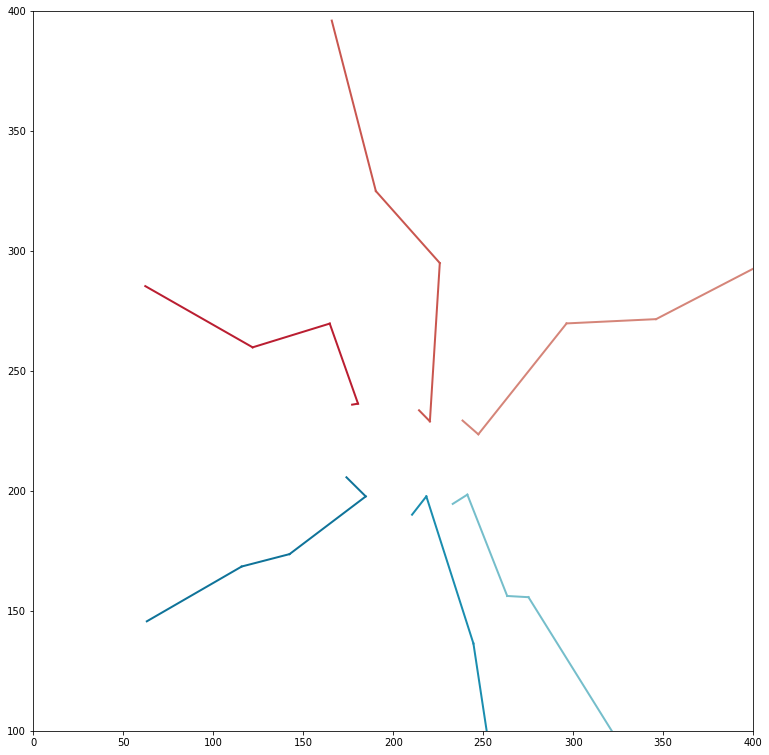

In [6]:
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
#plt.xlim([100,800])
#plt.ylim([100,800])

#bottom = _bottom.loc[0,(slice(None),['x','y'])]#
#bottom_np = pts2d.to_numpy()[None,:]
#bottom_np = _bottom.loc[:,(slice(None),['x','y'])].to_numpy()
#bottom_np = np.stack((bottom_np[:,::2], bottom_np[:,1::2]), axis=2)

from skeleton import skeleton
G, color_edge = skeleton()
writer = FFMpegWriter(fps=10)
with writer.saving(fig, "cropped.mp4", 100):
    for frame_idx in tqdm(range(1500)):
        plt.cla()

        #plt.imshow(img_rot[frame_idx], cmap='gray')
        #plt.imshow(imgs[frame_idx], cmap='gray')

        utils.plot_skeleton(G, bottom_np[frame_idx,:,0], bottom_np[frame_idx,:,1], color_edge)
        plt.xlim([0,400])
        plt.ylim([100,400])
                
        #plt.text(120, 80, str(frame_idx), fontsize=20, color='white')

        #plt.axis('off')
        writer.grab_frame() 

In [ ]:
shape

In [ ]:
import matplotlib.pyplot as plt
def plot_skeleton(x, y, color_edge,  ax=None, good_keypts=None):
           
    for i, j in enumerate(G.edges()): 
        if good_keypts is not None:
            if (good_keypts[j[0]]==0) | (good_keypts[j[1]]==0):
                continue   
       
        u = np.array((x[j[0]], x[j[1]]))
        v = np.array((y[j[0]], y[j[1]]))
        if ax is not None:
            ax.plot(u, v, c=color_edge[j[0]], alpha=1.0, linewidth = 2)
        else:
            plt.plot(u, v, c=color_edge[j[0]], alpha=1.0, linewidth = 2) 
            
from skeleton import skeleton
G, color_edge = skeleton()
#cropped image
i = 0

fig = plt.figure(figsize=(6,6))

bottom = _bottom.loc[:,(slice(None),['x','y'])]

tmp = procrustes.center_and_align(x, angle[0], np.array(shape), np.array(c[0]), img_rot[0])


bottom_x = bottom[:,0]
bottom_y = bottom[:,1]

plt.imshow(img_rot[0])
plot_skeleton(bottom_x, bottom_y, color_edge)


#i = 50

#bottom_2 = poses['points2d'][0,i,:,:].copy()

#bottom_x = bottom_2[:,0]
#bottom_y = bottom_2[:,1]

#plot_skeleton(bottom_x, bottom_y, color_edge)
